# Vehicle Detection

### Useful Libraries

In [1]:
import numpy as np
import pickle
import math
import os
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
from scipy import ndimage, misc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import collections

print('Libraries have been loaded')

Libraries have been loaded


### Loading Training Images

Number of vehicles images found:  8792
Number of non-vehicles images found:  8968
(64, 64, 3)
(64, 64, 3)


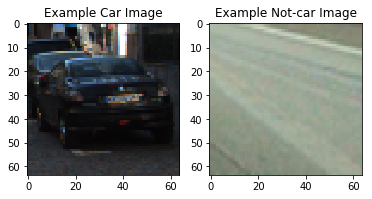

In [2]:
############### VEHICLES ###############
basedir = 'vehicles/'
typesdir = os.listdir(basedir)
vehicles = []
for image in typesdir:
    vehicles.extend(glob.glob(basedir+image+'/*'))

print ('Number of vehicles images found: ', len(vehicles))
with open("vehicles.txt", 'w') as f:
    for fn in vehicles:
        f.write(fn+'\n')

############### NON-VEHICLES ###############
basedir = 'non-vehicles/'
typesdir = os.listdir(basedir)
nonVehicles = []
for image in typesdir:
    nonVehicles.extend(glob.glob(basedir+image+'/*'))

print ('Number of non-vehicles images found: ', len(nonVehicles))
with open("non-vehicles.txt", 'w') as f:
    for fn in nonVehicles:
        f.write(fn+'\n')

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicles))
notcar_ind = np.random.randint(0, len(nonVehicles))
    
# Read in car / not-car images
car_image = mpimg.imread(vehicles[car_ind])
notcar_image = mpimg.imread(nonVehicles[notcar_ind])

print(car_image.shape)
print(notcar_image.shape)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

fig.savefig('output_images/Car_Not_Car.jpg')

### Useful Functions

In [3]:
### HISTOGRAMS OF COLOR ###
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    #bin_edges = rhist[1]
    #bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

### SPATIAL BINNING OF COLOR ###
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 

    # Use cv2.resize().ravel() to create the feature vector
    small_img = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return small_img

def bin_spatial2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


### HOG FEATURES ###
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
### EXTRACT RAW AND NORMALIZED FEATURES ###
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=16, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, color_space=color_space, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### EXTRACT FEATURES WITH HOG SUB-SAMPLING AND MAKE PREDICTIONS ###
def find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    
    scales = [1, 2, 3]
    box_list = []
    
    for scale in scales: # Extract features and test windows of different scales
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        #print(ch1.shape)
        #plt.imshow(ch1)
        #plt.show()
        ch2 = ctrans_tosearch[:,:,1]
        #print(ch2.shape)
        #plt.imshow(ch2)
        #plt.show()
        ch3 = ctrans_tosearch[:,:,2]
        #print(ch3.shape)
        #plt.imshow(ch3)
        #plt.show()

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 = original sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = window // pix_per_cell - cell_per_block + 1
        cells_per_step = 1  # Number of cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial2(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))     
                test_prediction = svc.predict(test_features)


                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    cv2.rectangle(draw_img, box[0], box[1] ,(0,0,255),6) 
                    box_list.append(box)
                
    #print('Spatial Features Shape ', spatial_features.shape)
    #print('Histogram Features Shape ', hist_features.shape)
    #print('Hog Features Shape ', hog_features.shape)

    return draw_img, box_list

### HEAT MAP ###
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
     
### THRESHOLD FOR HEATMAP ###
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #print(np.nonzero(heatmap))
    heatmap[heatmap <= threshold] = 0
    return heatmap

### DRAW LABELED BOXES ###
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### SMOOTH HEATMAP USING MEAN OR SUM OF HEATMAPS ###    
def smooth_heatmap(img, box_list, method):
    current_heatmap = add_heat(img, box_list)
    current_heatmap = apply_threshold(current_heatmap, 0)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
    nheatmaps = len(heatmaps)
    mean_heatmaps = heatmap_sum//nheatmaps
    
    if method == 'sum':
        return heatmap_sum
    
    elif method == 'mean':
        return mean_heatmaps

print('Functions have been loaded')

Functions have been loaded


### Hog Visualization & Extracting & Normalizing Raw Features

C:\Users\gabym\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


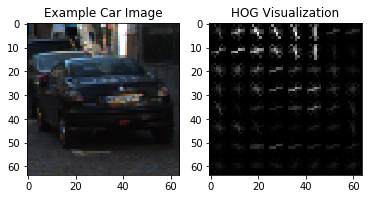

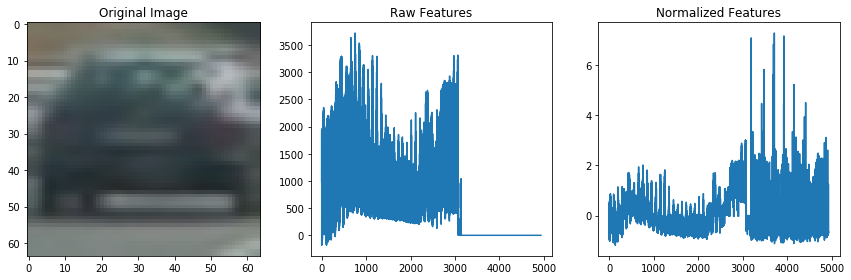

In [4]:
# Read in the image
train_image = mpimg.imread(vehicles[car_ind])
gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient_vis = 9
pix_per_cell_vis = 8
cell_per_block_vis = 2
# Call function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient_vis, 
                        pix_per_cell_vis, cell_per_block_vis, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(train_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.savefig('output_images/Hog_Visualization_Example.jpg')

sample_size = 500
cars = vehicles[0:sample_size]
notcars = nonVehicles[0:sample_size]

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

car_features_vis = extract_features(cars, color_space='LUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features_vis = extract_features(notcars, color_space='LUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)


if len(car_features_vis) > 0:
    # Create an array stack of feature vectors
    X_vis = np.vstack((car_features_vis, notcar_features_vis)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler_vis = StandardScaler().fit(X_vis)
    # Apply the scaler to X
    scaled_X_vis = X_scaler_vis.transform(X_vis)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X_vis[ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X_vis[ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    fig.savefig('output_images/Normalized_Hog_Features.jpg')
else: 
    print('Your function only returns empty feature vectors...')

### HOG Features Extraction, Classification & Predictions

In [5]:
# Define HOG parameters
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonVehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Make beeping noise when code cell is done running
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(3)

C:\Users\gabym\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


161.35 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6696
58.0 Seconds to train SVC...
Test Accuracy of SVC =  0.978
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  0.  1.]
For these 20 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  0.  1.]
0.02301 Seconds to predict 20 labels with SVC


0

### Hog Sub-sampling Window Search Method

C:\Users\gabym\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


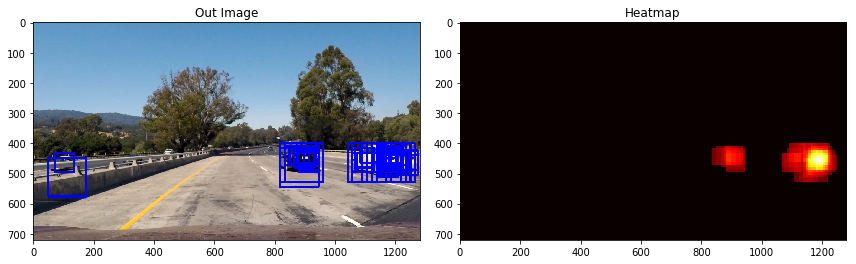

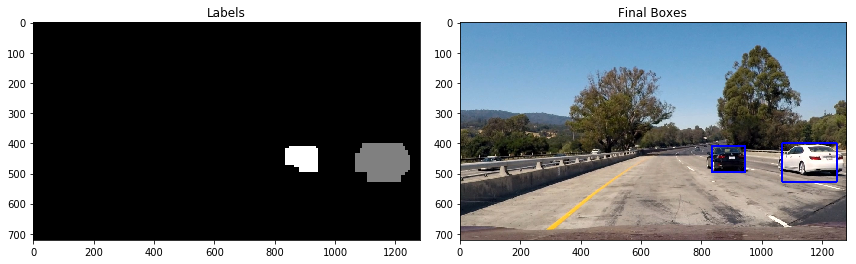

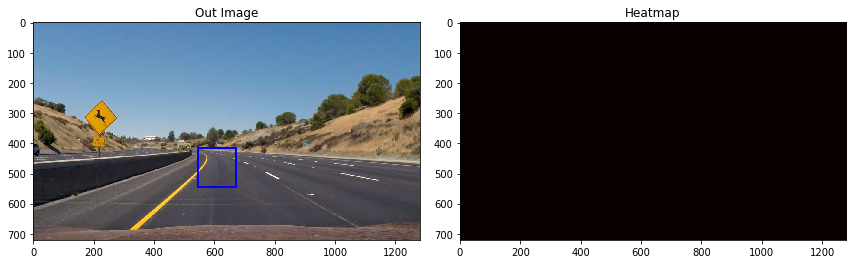

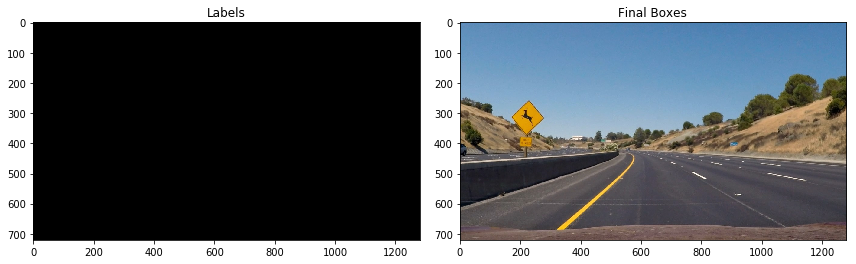

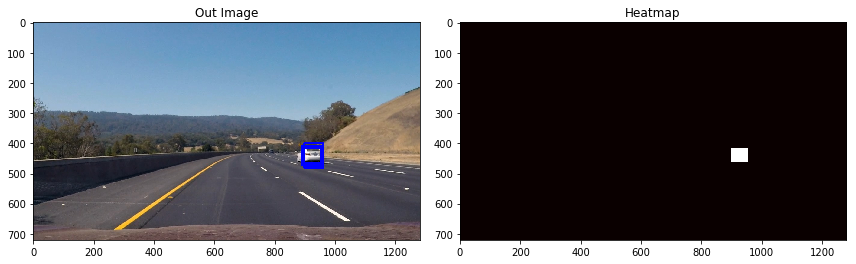

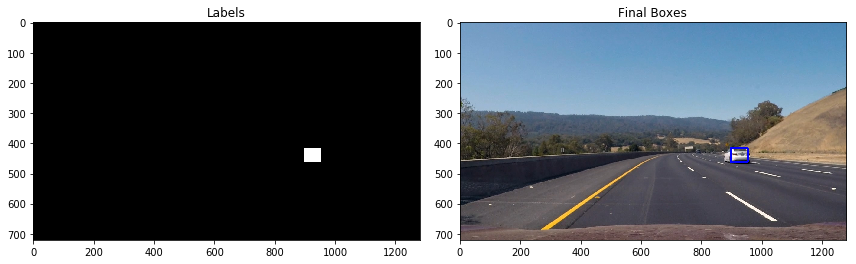

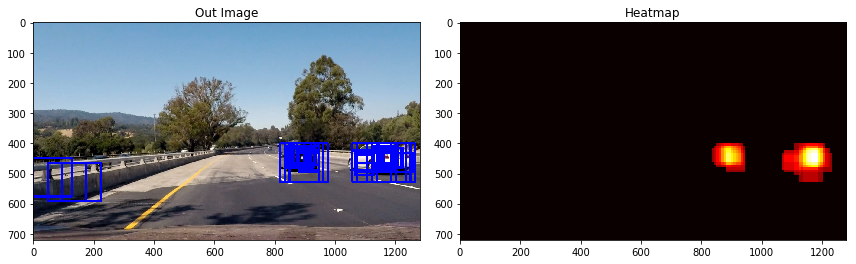

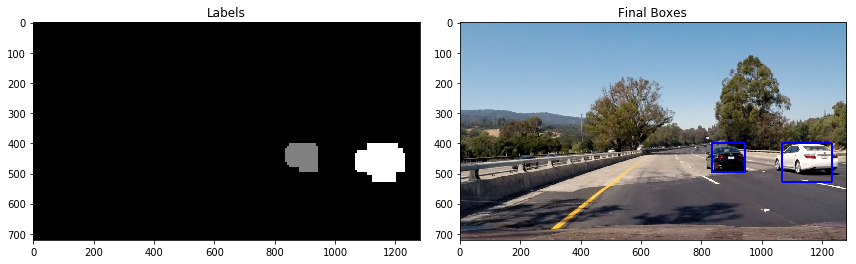

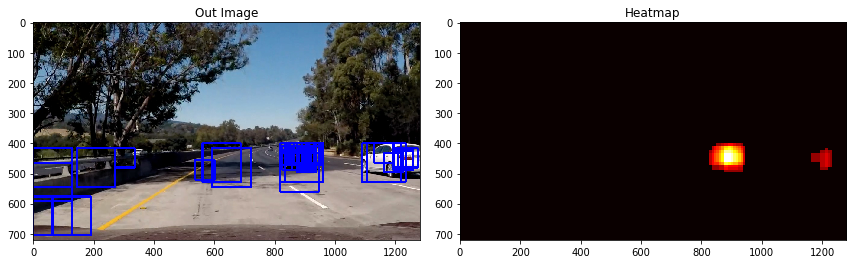

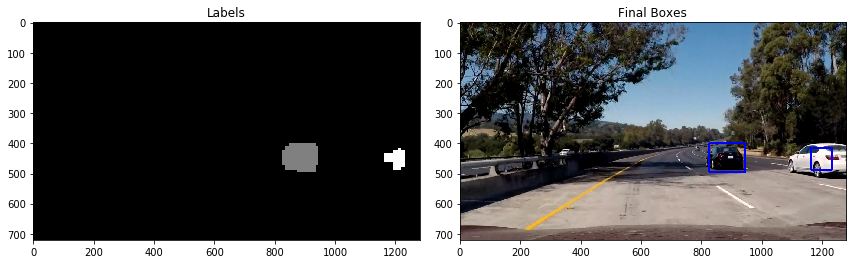

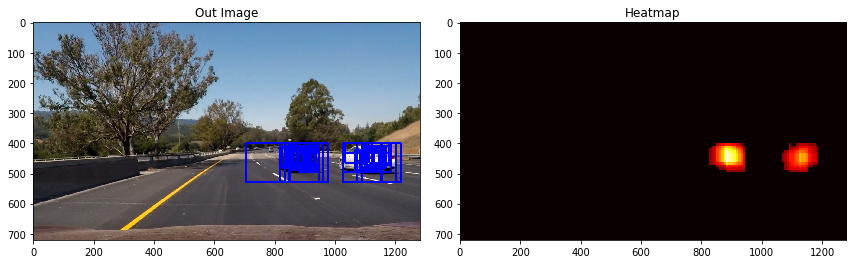

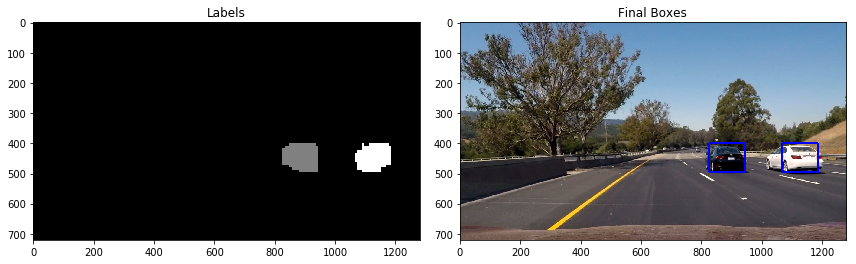

In [7]:
# find_cars parameters
ystart = 400
ystop = 720

images = glob.glob('test_images/test*.jpg')
threshold = 3
heatmaps = collections.deque(maxlen=5)

for fname in images:
    fname2 = fname.split('\\')
    image = mpimg.imread(fname)

    out_img, box_list = find_cars(image, ystart, ystop, svc, X_scaler, 
                                  orient, pix_per_cell, 
                                  cell_per_block, spatial_size, 
                                  hist_bins)

    fig1 = plt.figure(figsize=(12,4))    
    ############### HOG WINDOW SEARCH ###############    
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title('Out Image')

    ############### FULL HEATMAP ############### 
    # Empty heat array to store heat data
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Add heat to each box in box list and take the mean or sum
    #heat = smooth_heatmap(heat, box_list, 'mean')

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plt.subplot(122)
    plt.imshow(heatmap, cmap = 'hot')
    plt.title('Heatmap')

    fig1.tight_layout()
    fig1.savefig('output_images/Window_Search_&_Heatmap' + fname2[1])
    
    
    fig2 = plt.figure(figsize=(12,4))
    ############### LABELS HEATMAP ############### 
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    labels_img = labels[0]
    plt.subplot(121)
    plt.imshow(labels_img, cmap='gray')
    plt.title('Labels')

    ############### FINAL PLOT ############### 
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plt.subplot(122)
    plt.imshow(draw_img)
    plt.title('Final Boxes')
   
    fig2.tight_layout()
    fig2.savefig('output_images/Labels_&_Boxes' + fname2[1])


### Pipeline with `find_cars` Values, No Heatmap

In [8]:
def Rawpipeline(image):

    out_img, box_list = find_cars(image, ystart, 
                                  ystop, 
                                  svc, X_scaler, 
                                  orient, pix_per_cell, 
                                  cell_per_block, 
                                  spatial_size, hist_bins)

    return out_img

### Video Output of Rawpipeline

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'output_video/Vehicle_Tracking_Video_No_Heatmap.mp4'
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(40, 44)
white_clip = clip1.fl_image(Rawpipeline)
%time white_clip.write_videofile(output_video, audio=False)

# Make beeping noise when code cell is done running
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(3)

[MoviePy] >>>> Building video output_video/Vehicle_Tracking_Video_No_Heatmap.mp4
[MoviePy] Writing video output_video/Vehicle_Tracking_Video_No_Heatmap.mp4


 97%|█████████▋| 38/39 [07:23<00:12, 12.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/Vehicle_Tracking_Video_No_Heatmap.mp4 

Wall time: 7min 25s


0

### Pipeline with Heatmap Values

In [10]:
def Mypipeline(image):

    out_img, box_list = find_cars(image, ystart, 
                                  ystop, 
                                  svc, X_scaler, 
                                  orient, pix_per_cell, 
                                  cell_per_block, 
                                  spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

### Video Output of Mypipeline

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'output_video/Vehicle_Tracking_Video_Heatmap.mp4'
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(40, 44)
white_clip = clip1.fl_image(Mypipeline)
%time white_clip.write_videofile(output_video, audio=False)

# Make beeping noise when code cell is done running
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(3)

[MoviePy] >>>> Building video Vehicle_Tracking_Video_Heatmap.mp4
[MoviePy] Writing video Vehicle_Tracking_Video_Heatmap.mp4


 97%|█████████▋| 38/39 [07:42<00:11, 11.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Vehicle_Tracking_Video_Heatmap.mp4 

Wall time: 7min 44s


0

### Pipeline with Mean of Heatmap Values

In [ ]:
heatmaps = collections.deque(maxlen=15)

def Mypipeline2(image):
    
    out_img, box_list = find_cars(image, ystart, ystop, 
                                      svc, X_scaler, 
                                      orient, pix_per_cell, 
                                      cell_per_block, spatial_size, 
                                      hist_bins)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heat = smooth_heatmap(heat, box_list, 'mean')
    
    heat = apply_threshold(heat, 3)

    final_heatmap = np.clip(heat, 0, 255)

    labels = label(final_heatmap)
    labels_img = labels[0]

    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

### Video Output of Mypipeline2

In [ ]:
## Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'output_video/Vehicle_Tracking_Video_Heatmap_Smooth.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(40, 44)
white_clip = clip1.fl_image(Mypipeline2)
%time white_clip.write_videofile(output_video, audio=False)

# Make beeping noise when code cell is done running
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(3)